In [33]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage import io
from skimage.morphology import opening, closing
from skimage.morphology import disk

from LDA import LDA

In [34]:
in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM']
ROI_WM = data['ROI_WM']

## Ex 1

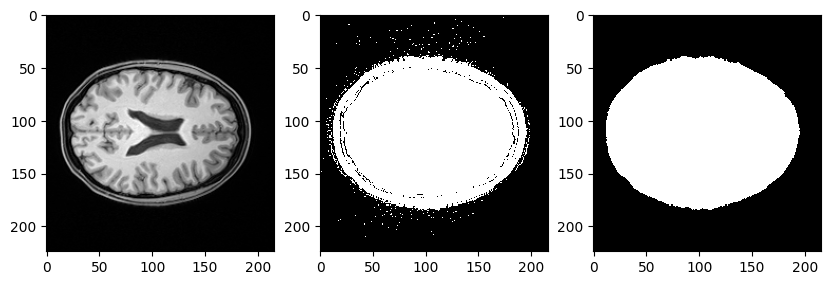

In [35]:
mask_init = ImgT1 > 12
mask = opening(mask_init, disk(2))
mask = closing(mask, disk(3))

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
axs[0].imshow(ImgT1, cmap = 'gray')
axs[1].imshow(mask_init, cmap = 'gray', interpolation = 'none')
axs[2].imshow(mask, cmap = 'gray', interpolation = 'none')
plt.show()

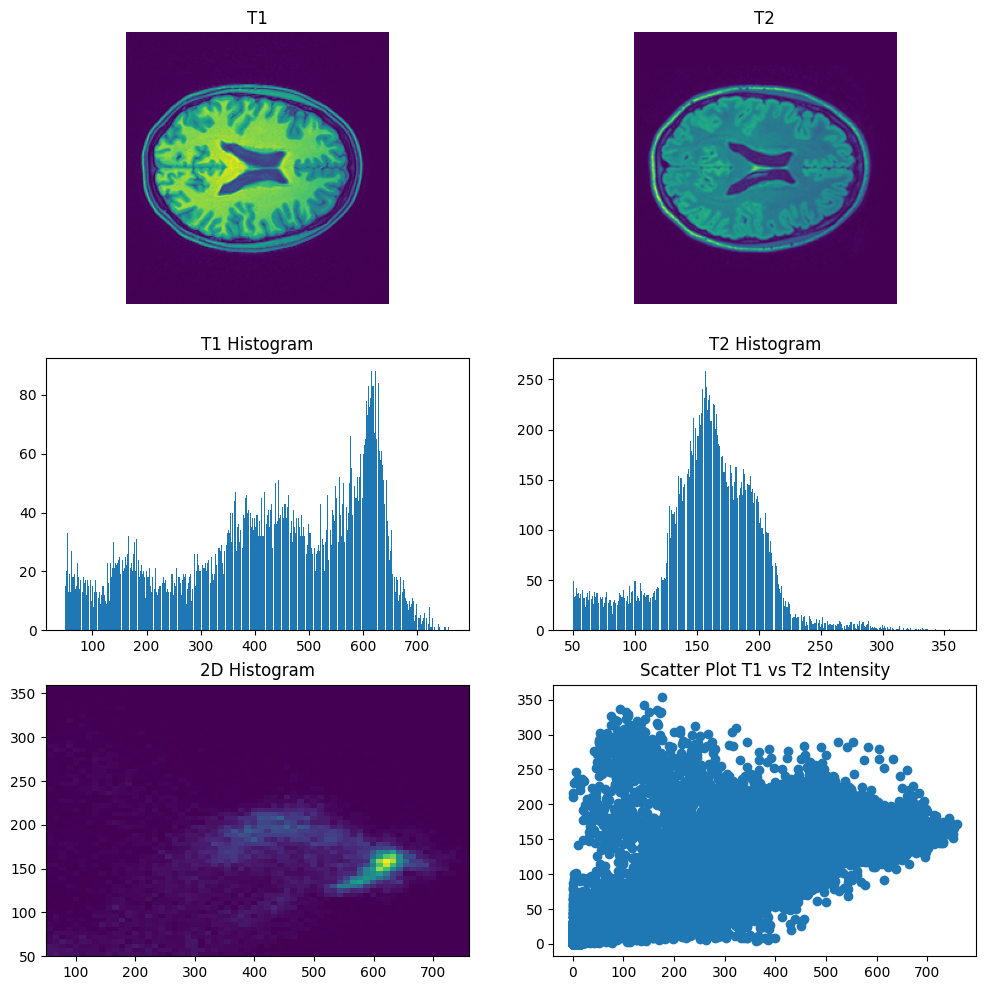

In [36]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(12, 12))
ax1.imshow(ImgT1)
ax1.set_title('T1')
ax1.axis('off')

ax2.imshow(ImgT2)
ax2.set_title('T2')
ax2.axis('off')

ax3.hist(ImgT1.ravel(), bins=758, range=(50,760))
ax3.set_title('T1 Histogram')

ax4.hist(ImgT2.ravel(), bins=354, range=(50,360))
ax4.set_title('T2 Histogram')

ax5.hist2d(ImgT1.ravel(), ImgT2.ravel(), bins=64, range=((50, 760), (50,360)))
ax5.set_title('2D Histogram')

ax6.scatter(ImgT1.ravel(), ImgT2.ravel())
ax6.set_title('Scatter Plot T1 vs T2 Intensity')

io.show()

#### Q1: What is the intensity threshold that can separate the GM and WM classes (roughly) from the 1D histograms?
Around 500 for T1 and 180 for T2

#### Q2: Can the GM and WM intensity classes be observed in the 2D histogram and scatter plot?
These intensity classes are visible as blobs in the 2d histogram

Text(0.5, 1.0, 'ROI_GM T2')

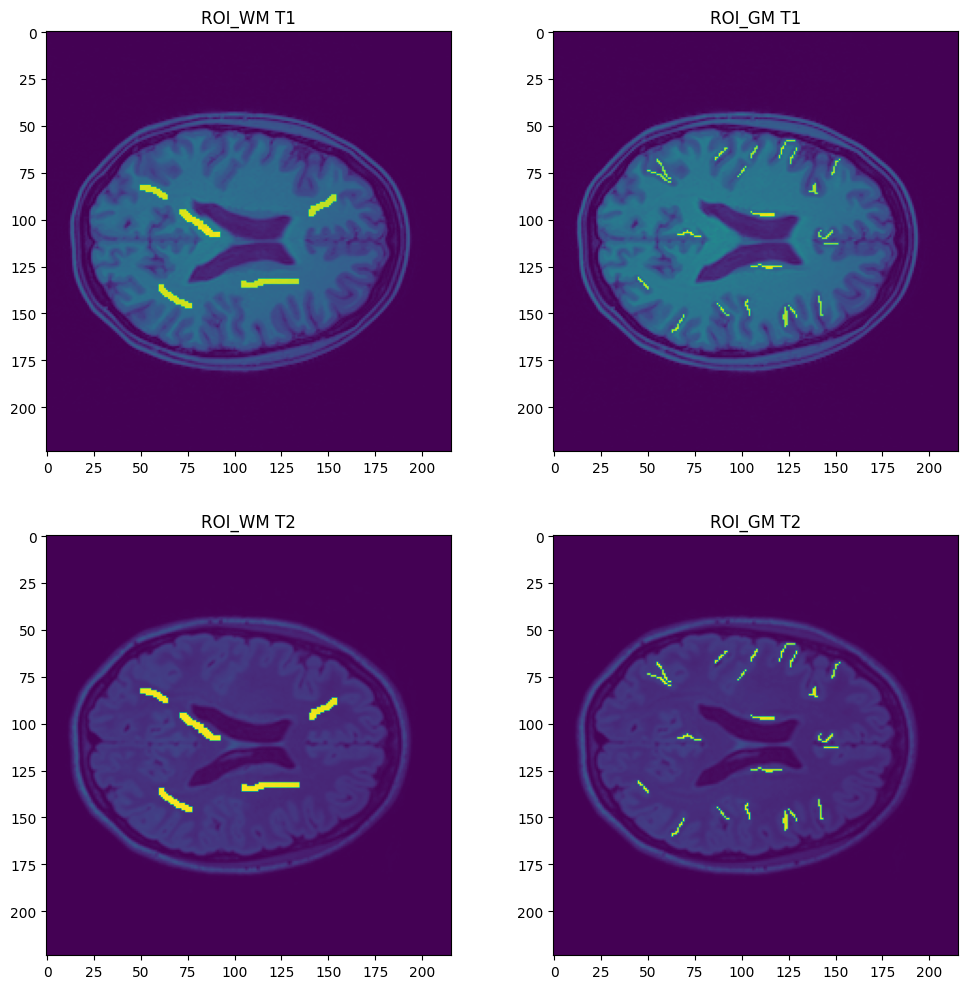

In [37]:
C1 = ROI_WM
C2 = ROI_GM

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
ax1.imshow(C1 + 0.001 * ImgT1)
ax1.set_title('ROI_WM T1')

ax2.imshow(C2 + 0.001 * ImgT1)
ax2.set_title('ROI_GM T1')

ax3.imshow(C1 + 0.001 * ImgT2)
ax3.set_title('ROI_WM T2')

ax4.imshow(C2 + 0.001 * ImgT2)
ax4.set_title('ROI_GM T2')

In [38]:
bin_WM = C1 > 0.5  
ImgT1_WM = bin_WM * ImgT1
ImgT2_WM = bin_WM * ImgT2

bin_GM = C2 > 0.5
ImgT1_GM = bin_GM * ImgT1
ImgT2_GM = bin_GM * ImgT2

Text(0.5, 1.0, 'T2 GM Histogram')

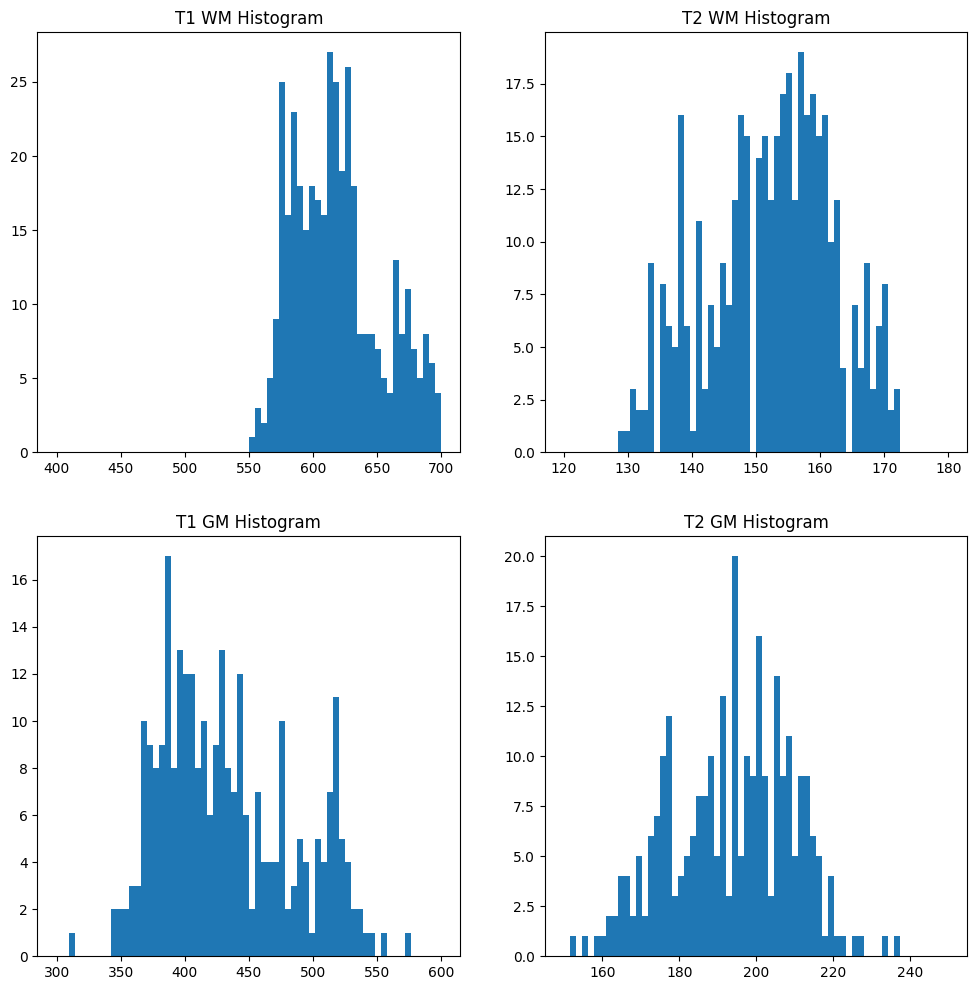

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
ax1.hist(ImgT1_WM.ravel(), bins=64, range=(400,700))
ax1.set_title('T1 WM Histogram')

ax2.hist(ImgT2_WM.ravel(), bins=64, range=(120,180))
ax2.set_title('T2 WM Histogram')

ax3.hist(ImgT1_GM.ravel(), bins=64, range=(300,600))
ax3.set_title('T1 GM Histogram')

ax4.hist(ImgT2_GM.ravel(), bins=64, range=(150,250))
ax4.set_title('T2 GM Histogram')

#### Q4: What is the difference between the 1D histogram of the training examples and the 1D histogram of the whole image? Is the difference expected?

The two clusters shown in the 2D hist of the whole image are not separated by brain tissue type. Grey matter is the higher intensity peak in the T1 image and the lower intensity peak in the T2 image.

In [40]:
wm_index = np.argwhere(C1 > 0)
gm_index = np.argwhere(C2 > 0)

X1 = []
X2 = []
T = []
im1_WM = []
im2_WM = []
im1_GM = []
im2_GM = []

for x in wm_index:
    intensity_T1 = ImgT1[x[0]][x[1]]
    intensity_T2 = ImgT2[x[0]][x[1]]
    label = 0
    
    im1_WM.append(intensity_T1)
    im2_WM.append(intensity_T2)
    X1.append(intensity_T1)
    X2.append(intensity_T2)
    T.append(label)    
    
for x in gm_index:
    intensity_T1 = ImgT1[x[0]][x[1]]
    intensity_T2 = ImgT2[x[0]][x[1]]
    label = 1
    
    im1_GM.append(intensity_T1)
    im2_GM.append(intensity_T2)
    X1.append(intensity_T1)
    X2.append(intensity_T2)
    T.append(label)

T = np.array(T)
X = np.column_stack((X1, X2))

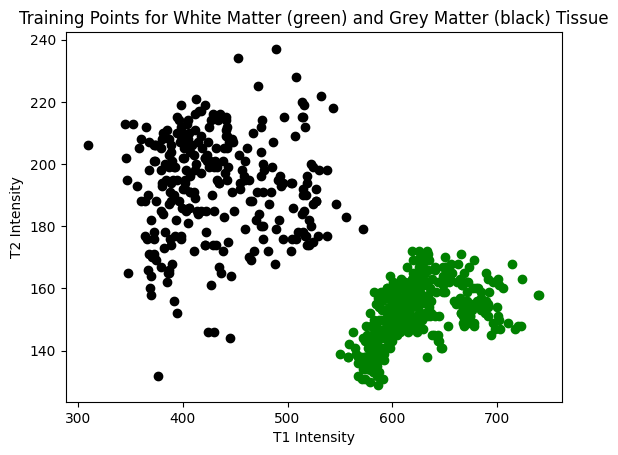

In [41]:
plt.scatter(im1_WM, im2_WM, color='green')
plt.scatter(im1_GM, im2_GM, color='black')
plt.title('Training Points for White Matter (green) and Grey Matter (black) Tissue')
plt.xlabel('T1 Intensity')
plt.ylabel('T2 Intensity')
plt.show()

### Q5: How does the class separation appear in the 2D scatter plot compared with 1D histogram. Is it better?
Class separation is clearer in the 2D scatter plot as only labelled data points are present

In [53]:
W = LDA(X, T)

In [54]:
Xall= np.c_[ImgT1[mask].flatten(), ImgT2[mask].flatten()]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T

In [55]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:,np.newaxis], 0, 1)

In [64]:
posteriorC1 = np.zeros(ImgT1.shape)
posteriorC2 = np.zeros(ImgT1.shape)

posteriorC1[mask] = PosteriorProb[:,0]
posteriorC2[mask] = PosteriorProb[:,1]
mask_WM = posteriorC1 >= 0.5
mask_GM = posteriorC2 >= 0.5

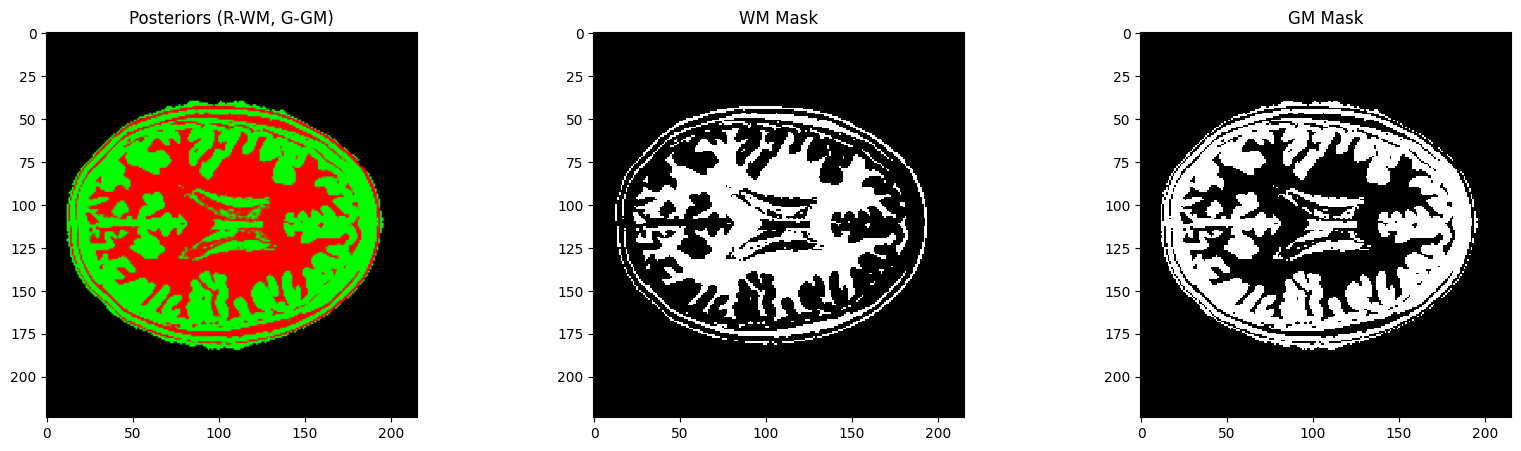

In [58]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))
rgb = np.stack((posteriorC1, posteriorC2, np.zeros_like(posteriorC1)), axis = -1).astype(np.double)
axs[0].imshow(rgb)
axs[0].set_title('Posteriors (R-WM, G-GM)')
axs[1].imshow(mask_WM, cmap = 'gray', interpolation = 'none')
axs[1].set_title('WM Mask')
axs[2].imshow(mask_GM, cmap='gray', interpolation = 'none')
axs[2].set_title('GM Mask')
plt.show()

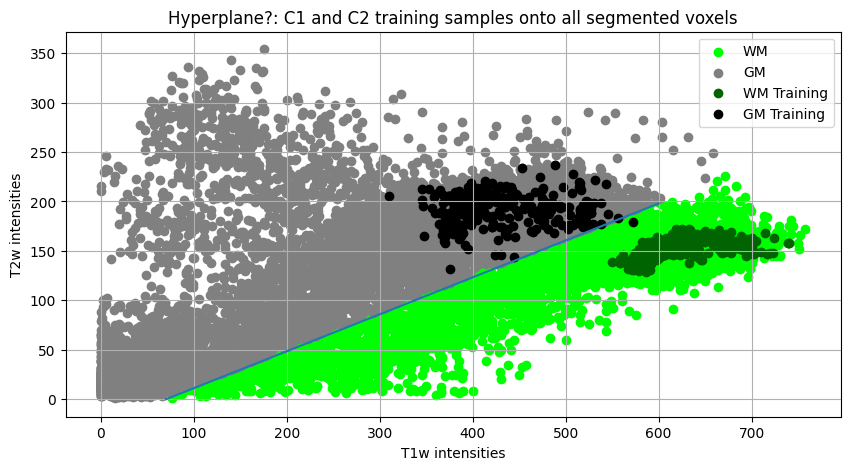

In [86]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(im1_C1, im2_C1, c = 'lime', label = 'WM')
ax.scatter(im1_C2, im2_C2, c = 'grey', label = 'GM')
ax.scatter(im1_WM, im2_WM, c = 'darkgreen', label = 'WM Training')
ax.scatter(im1_GM, im2_GM, c = 'black', label = 'GM Training')

ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
ax.set_title('Hyperplane?: C1 and C2 training samples onto all segmented voxels')
ax.grid()
ax.plot([70,600], [0,198])
plt.legend()
plt.show()

### Q6 Can you identify where the hyperplane is placed i.e. y(x)=0?
Yes a clear linear boundary is visible between classes

### Q7 Is the linear hyper plane positioned as you expected or would a non-linear hyper plane perform better?
Positioned fairly well but some black data points appear to cross the hyperplane drawn

### Q8 Would segmentation be as good as using a single image modality using thresholding?
No, if a single image modality with thresholding were sufficient, the hyperplane could be drawn orthogonal to one of the axes. This is not the case

### Q9 From the scatter plot does the segmentation results make sense? Are the two tissue types segmented correctly.
Looks good based on our labelled training data

### Q10 Are the training examples representative for the segmentation results? Are you surprised that so few training examples perform so well? Do you need to be an anatomical expert to draw these?


### Q11 Compare the segmentation results with the original image. Are the segmentation results satisfactory? Why not?

### Q12 Is one class completely wrong segmented? What is the problem?
Background and skull voxels are also classified